In [ ]:
#If the notebook is being checked over, please give any advice, changes, suggestions, etc
#as to what I can do, add, or modify to filter this better

#Link to the notebook: https://colab.research.google.com/drive/12IMDKfhKrTYu3WQLstDeuz6pwCehLqj_?usp=sharing

In [ ]:
#Kaggle Link: https://www.kaggle.com/jboysen/global-food-prices

In [56]:
#Medium Link: https://medium.com/@adamvu1087/global-food-price-predictions-e2bd9fb130fa

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/main/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap
# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/Kaggle

/content/drive/MyDrive/Colab Notebooks/Kaggle


In [ ]:
%ls

2021-11-03_2237_AV_GS_Kaggle.csv  country_region.csv
2021-11-04_0230_AV_GS_Kaggle.csv  test_features.csv
Adam_Vu_Submission.csv            train_features.csv
AV_RandomForest1_Submission.csv   train_labels.csv
AV_RandomForest_Submission.csv    wfp_market_food_prices.csv


In [ ]:
#Import Respective Libraries and Any Extras if Needed
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
 #Loading the CSV First before Wrangling
 df = pd.read_csv('wfp_market_food_prices.csv', encoding='latin-1', index_col='adm0_id')
 df

,adm0_name,adm1_id,adm1_name,mkt_id,mkt_name,cm_id,cm_name,cur_id,cur_name,pt_id,pt_name,um_id,um_name,mp_month,mp_year,mp_price,mp_commoditysource
adm0_id,,,,,,,,,,,,,,,,,
1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread,87,AFN,15,Retail,5,KG,1,2014,50.0,WFP
1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread,87,AFN,15,Retail,5,KG,2,2014,50.0,WFP
1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread,87,AFN,15,Retail,5,KG,3,2014,50.0,WFP
1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread,87,AFN,15,Retail,5,KG,4,2014,50.0,WFP
1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread,87,AFN,15,Retail,5,KG,5,2014,50.0,WFP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70001,South Sudan,2750,Eastern Equatoria,1786,Torit,156,Sesame,83,SSP,15,Retail,47,3.5 KG,5,2017,400.0,WFP
70001,South Sudan,2750,Eastern Equatoria,1786,Torit,284,Fuel (diesel),83,SSP,15,Retail,15,L,2,2017,12.5,WFP
70001,South Sudan,2750,Eastern Equatoria,1786,Torit,284,Fuel (diesel),83,SSP,15,Retail,15,L,3,2017,95.0,WFP


In [ ]:
#Wrangling to Provide better efficiency and cleanliness 
def wrangle(filepath):
    df = pd.read_csv('wfp_market_food_prices.csv', encoding='latin-1', index_col='adm0_id')
    df.drop(columns=['cur_id', 'cur_name', 'pt_id', 'pt_name', 'mp_commoditysource', 
                     'um_id', 'adm1_name','um_name', 'mkt_id', 'adm1_id', 'cm_id'], inplace=True)
    df = df.merge(countrylist, left_on='adm0_name', right_on='Country')
    monthchange = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'June', 6: 'July',
                   7: 'July', 8: 'August', 9: 'September', 10: 'October', 11:'November', 12:'December'}
    df.replace({'mp_month': monthchange}, inplace=True)

    return df 

In [ ]:
#Other Dataset Used for Merging
countrylist = pd.read_csv('country_region.csv')

countrylist.sort_values(by=' Region')



,Country,Region
39,Congo,Africa
146,Mauritius,Africa
38,Central African Republic,Africa
78,Ghana,Africa
41,Côte D'Ivoire,Africa
...,...,...
83,Guadeloupe,South/Latin America
199,Suriname,South/Latin America
37,Congo,The Democratic Republic of the
230,Virgin Islands,U.S.


In [ ]:
#The Wrangled Dataframe
df = wrangle(df)
df

,adm0_name,mkt_name,cm_name,mp_month,mp_year,mp_price,Country,Region
0,Afghanistan,Fayzabad,Bread,January,2014,50.0,Afghanistan,Asia & Pacific
1,Afghanistan,Fayzabad,Bread,February,2014,50.0,Afghanistan,Asia & Pacific
2,Afghanistan,Fayzabad,Bread,March,2014,50.0,Afghanistan,Asia & Pacific
3,Afghanistan,Fayzabad,Bread,April,2014,50.0,Afghanistan,Asia & Pacific
4,Afghanistan,Fayzabad,Bread,June,2014,50.0,Afghanistan,Asia & Pacific
...,...,...,...,...,...,...,...,...
697977,South Sudan,Torit,Sesame,June,2017,400.0,South Sudan,Africa
697978,South Sudan,Torit,Fuel (diesel),February,2017,12.5,South Sudan,Africa
697979,South Sudan,Torit,Fuel (diesel),March,2017,95.0,South Sudan,Africa
697980,South Sudan,Torit,Fuel (petrol-gasoline),February,2017,95.0,South Sudan,Africa


In [ ]:
#Applying the Filter
df[['adm0_name', 'Country']]

,adm0_name,Country
0,Afghanistan,Afghanistan
1,Afghanistan,Afghanistan
2,Afghanistan,Afghanistan
3,Afghanistan,Afghanistan
4,Afghanistan,Afghanistan
...,...,...
697977,South Sudan,South Sudan
697978,South Sudan,South Sudan
697979,South Sudan,South Sudan
697980,South Sudan,South Sudan


In [ ]:
df.columns

#While I do have quite a few columns albeit most are not really predictable persay,
#I think the column I can best predict would be mp_price. Considering that mp_price,
#is a constantly changing value, it is only natural for it to be a regression problem.
#

Index(['adm0_name', 'mkt_name', 'cm_name', 'mp_month', 'mp_year', 'mp_price',
       'Country', ' Region'],
      dtype='object')

In [ ]:
#Checking names to see if this is a good method
df['adm0_name'].unique()

array(['Afghanistan', 'Algeria', 'Armenia', 'Azerbaijan', 'Bangladesh',
       'Benin', 'Bhutan', 'Bolivia', 'Burkina Faso', 'Burundi',
       'Cambodia', 'Cameroon', 'Cape Verde', 'Central African Republic',
       'Chad', 'Colombia', 'Congo', 'Costa Rica', 'Djibouti',
       'El Salvador', 'Ethiopia', 'Gambia', 'Georgia', 'Ghana',
       'Guatemala', 'Guinea-Bissau', 'Guinea', 'Haiti', 'Honduras',
       'India', 'Indonesia', 'Iraq', 'Jordan', 'Kenya', 'Kyrgyzstan',
       "Lao People's Democratic Republic", 'Lebanon', 'Lesotho',
       'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania',
       'Mozambique', 'Myanmar', 'Nepal', 'Niger', 'Nigeria', 'Pakistan',
       'Panama', 'Peru', 'Philippines', 'Rwanda', 'Senegal', 'Somalia',
       'Sri Lanka', 'Swaziland', 'Syrian Arab Republic', 'Tajikistan',
       'Timor-Leste', 'Turkey', 'Uganda', 'Ukraine', 'Yemen', 'Zambia',
       'Zimbabwe', 'Sudan', 'Egypt', 'South Sudan'], dtype=object)

In [ ]:
#Picking a region from the list that has a reasonable amount of entries
df[' Region'].unique()

array([' Asia & Pacific', ' Arab States', ' Europe', ' Africa',
       ' South/Latin America', ' The Democratic Republic of the',
       ' Middle east'], dtype=object)

In [ ]:
#Making a subset of the Data as to not overload the model
Europe = df.loc[(df[' Region'] == ' Europe')]

Europe

,adm0_name,mkt_name,cm_name,mp_month,mp_year,mp_price,Country,Region
6460,Armenia,Yerevan,Wheat flour,April,2011,300.0000,Armenia,Europe
6461,Armenia,Yerevan,Wheat flour,June,2011,270.0000,Armenia,Europe
6462,Armenia,Yerevan,Wheat flour,July,2011,270.0000,Armenia,Europe
6463,Armenia,Yerevan,Wheat flour,July,2011,270.0000,Armenia,Europe
6464,Armenia,Yerevan,Wheat flour,August,2011,270.0000,Armenia,Europe
...,...,...,...,...,...,...,...,...
649742,Ukraine,Kiev,Fat (salo),February,2017,39.8700,Ukraine,Europe
649743,Ukraine,Kiev,Fat (salo),March,2017,39.8700,Ukraine,Europe
649744,Ukraine,Kiev,Fat (salo),April,2017,39.8700,Ukraine,Europe
649745,Ukraine,Kiev,Fat (salo),June,2017,39.8700,Ukraine,Europe


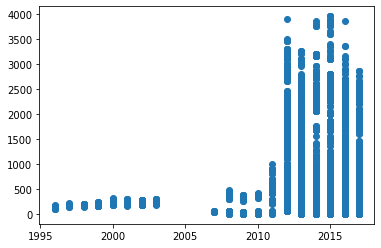

In [ ]:
plt.scatter(Europe['mp_year'], Europe['mp_price'])

In [ ]:
#Choosing my X and y
target = 'mp_price'
X = Europe.drop(columns=target)
y = Europe[target]

In [ ]:
#Splitting the Data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.2, random_state=42)

In [ ]:
#Establishing a Baseline
from sklearn.metrics import mean_absolute_error

baseline_pred = [y_test.mean()] * len(y_test)

mean_absolute_error(y_test, baseline_pred)

226.9778398994199

In [ ]:
# Building First Model
from sklearn.linear_model import LinearRegression
enc = OneHotEncoder(sparse=False)
X_transform = enc.fit_transform(X)
model_lr = LinearRegression()
model_lr.fit(X_transform, y)

LinearRegression()

In [ ]:
y_pred_lr = model_lr.predict(X_transform)

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y, y_pred_lr)

110.85367283069574

In [ ]:
#Building my Second Model
from sklearn.ensemble import RandomForestRegressor
model_rf = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestRegressor(random_state=42, n_jobs=-1)
)

model_rf.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('simpleimputer', SimpleImputer()),
                ('randomforestregressor',
                 RandomForestRegressor(n_jobs=-1, random_state=42))])

In [ ]:
print("Training Accuracy - Random Forest", mean_absolute_error(y_train, model_rf.predict(X_train)))
print("Validation Accuracy - Random Forest", mean_absolute_error(y_test, model_rf.predict(X_test)))

Training Accuracy - Random Forest 4.036683288269523
Validation Accuracy - Random Forest 9.982991823785


In [ ]:
#Building Final Model
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBRegressor

model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBRegressor(random_state=42, n_estimators=75, n_jobs=-1)
)

model_xgb.fit(X_train, y_train)

In [ ]:
print(mean_absolute_error(y_train, model_xgb.predict(X_train)))
print(mean_absolute_error(y_test, model_xgb.predict(X_test)))

47.37237495534446
46.70640667321839


In [ ]:
print('validation accuracy', model_xgb.score(X_test,y_test))

validation accuracy 0.9361507421120437


In [ ]:
#Code to prep for importances
col = 'mp_year'
X_test_perm = X_test.copy()
X_test_perm[col] = np.random.permutation(X_test_perm[col])

In [ ]:
from sklearn.inspection import permutation_importance 
perm_importance = permutation_importance(model_xgb, X_test, y_test, random_state=42)

perm_importance

Text(0, 0.5, 'Feature')

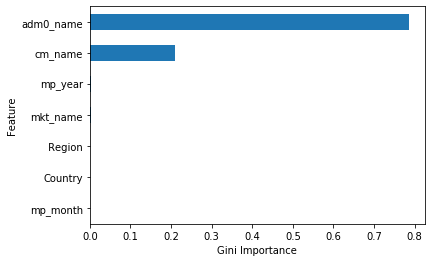

In [ ]:
#finding gini importances
importances = model_xgb.named_steps['xgbregressor'].feature_importances_
feature_names = X_train.columns
feat_imp = pd.Series(data=importances, index=feature_names).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')

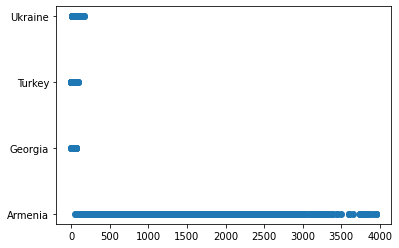

In [ ]:
plt.scatter(Europe['mp_price'], Europe['adm0_name'])

In [ ]:
#India = df[df['Country'] == 'India']

India = df.loc[(df['adm0_name'] == 'India')  & (df['mkt_name'] == 'Agartala') & (df['cm_name'] == 'Rice') ]

India

,adm0_name,mkt_name,cm_name,mp_month,mp_year,mp_price,Country,Region
123440,India,Agartala,Rice,January,1996,8.00,India,Asia & Pacific
123441,India,Agartala,Rice,March,1996,8.50,India,Asia & Pacific
123442,India,Agartala,Rice,April,1996,8.75,India,Asia & Pacific
123443,India,Agartala,Rice,June,1996,8.75,India,Asia & Pacific
123444,India,Agartala,Rice,July,1996,8.50,India,Asia & Pacific
...,...,...,...,...,...,...,...,...
123683,India,Agartala,Rice,February,2017,28.94,India,Asia & Pacific
123684,India,Agartala,Rice,March,2017,29.00,India,Asia & Pacific
123685,India,Agartala,Rice,April,2017,30.25,India,Asia & Pacific
123686,India,Agartala,Rice,June,2017,31.00,India,Asia & Pacific


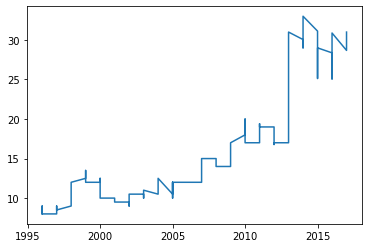

In [ ]:
time = India['mp_year']
cost = India['mp_price']

plt.plot(time,cost)
plt.show()

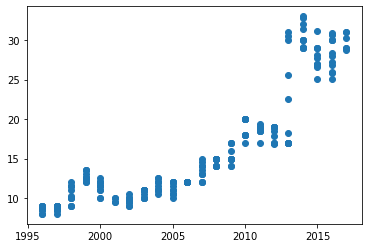

In [ ]:
plt.scatter(India['mp_year'], India['mp_price'])

In [ ]:
India.describe()

,mp_year,mp_price
count,248.000000,248.000000
mean,2006.447581,15.969234
std,6.231472,6.999458
min,1996.000000,8.000000
25%,2001.000000,11.000000
50%,2007.000000,13.000000
75%,2012.000000,19.000000
max,2017.000000,33.000000
